<a href="https://colab.research.google.com/github/RealMyeong/Going_Deeper_NLP/blob/main/GoingDeeper(NLP)_2_%EB%8B%A8%EC%96%B4%EC%82%AC%EC%A0%84%EB%A7%8C%EB%93%A4%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

이번에는 여러 한국어 형태소 분석기를 사용해보고 결과를 비교해보겠습니다.

먼저 실습을 진행할 google colab의 환경 설정을 해줍니다.


In [ ]:
!apt-get update
!apt-get install g++ openjdk-8-jdk
!pip install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
!pip install --upgrade gensim
# !pip install --upgrade keras==2.6.0
# !pip install --upgrade tensorflow==2.6.0

In [ ]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

In [ ]:
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
import tensorflow
import keras

In [ ]:
from konlpy.tag import Mecab

mecab = Mecab()

사용할 데이터는 한국어의 형태소 분석과 품사 태깅, 기계 번역 연구를 위해 공개된 데이터입니다. 이번에 사용할 데이터는 한국어-영어 병렬을 이루는 말뭉치 중 한국어 부분으로, 전체 병렬 말뭉치는 후에 번역기를 만들며 사용할 예정입니다

다른 데이터를 사용하고 싶으시면 아래 주소로 가시면 됩니다.  
https://github.com/jungyeul/korean-parallel-corpora

데이터를 불러오겠습니다.

In [ ]:
file_path = '/content/drive/MyDrive/AIFFEL/GoingDeeper(NLP)/2_단어사전만들기/korean-english-park.train.ko'

with open(file_path, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


문장은 위에서 확인한 것처럼 94123개가 포함되어 있습니다. 우리는 각 문장이 어느 정도의 길이를 가지는지 확인해보겠습니다! 이 과정을 거치면 지나치게 긴 데이터를 삭제하거나 (연산량을 감소시켜 학습 속도가 빨라집니다!) 지나치게 짧은 데이터를 검증 (무조건 필요가 없지는 않습니다, 단어 ↔ 단어 라면 번역을 학습할 수 있겠죠!) 할 수 있습니다. 즉, 데이터를 얼마나 사용할지 타협점을 정의할 수 있습니다.

아래 소스는 문장의 최단 길이, 최장 길이, 평균 길이를 구한 후 문장 길이 분포를 막대그래프로 표현해 주는 소스입니다. raw 변수는 앞서 다운로드받은 데이터가 담긴 변수입니다!

문장의 최단 길이 :  1
문장의 최장 길이 :  377
문장의 평균 길이 :  60


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


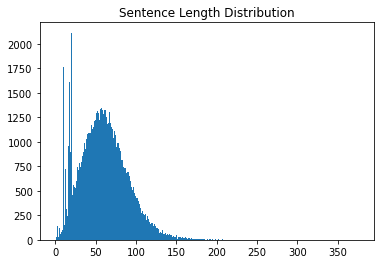

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
  length = len(sen)
  if min_len > length : 
    min_len = length
  if max_len < length:
    max_len = length
  sum_len += length

print('문장의 최단 길이 : ', min_len)
print('문장의 최장 길이 : ', max_len)
print('문장의 평균 길이 : ', sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in raw:
  sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title('Sentence Length Distribution')
plt.show()

위 그림을 보면 약간 이상한 점이 있습니다.

1. 길이 1짜리 문장은 무언인지
2. 그림에서 치솟는 임의의 구간은 무엇인지
3. 어디서부터 어디까지 잘라서 써야하는지

하나하나 살펴보겠습니다.


In [ ]:
# 길이가 1인 문장 확인
def check_sentence_with_length(raw, length):
  count = 0

  for sen in raw:
    if len(sen) == length:
      print(sen)
      count += 1
      if count > 100:
        return
  
check_sentence_with_length(raw, 1)

’


이번에는 문장의 수가 1500을 초과하는 문장 길이를 추출하겠습니다.


In [ ]:
for idx, _sum in enumerate(sentence_length):
  if _sum > 1500:
    print('Outlier Index : ', idx+1)

Outlier Index :  11
Outlier Index :  19
Outlier Index :  21


In [ ]:
check_sentence_with_length(raw, 11)

라고 조던이 말했다.
- 모르고 있습니다.
- 네, 보이는군요.
디즈니사만이 아니다.
큰 파티는 아니지요.
의자는 비어 있었다.
이 일은 계속됩니다.
나는 크게 실망했다.
그 이유는 간단하다.
이력서와 자기 소개서
시대가 변하고 있다.
는 돌발질문을 했다.
9. 몇 분간의 명상
하와이, 빅 아일랜드
키스를 잘 하는 방법
키스를 잘 하는 방법
스피어스가 뚱뚱한가?
산 위를 나는 느낌.
세 시간쯤 걸었을까?
(아직 읽고있습니까?
처음에는 장난이었다.
우리는 운이 좋았다.
아기가 숨을 멈출 때
건물 전체 무너져내려
그녀의 아름다운 눈.
대답은 다음과 같다.
"사과할 것이 없다.
폭탄테러가 공포 유발
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1

중복치가 제거되지 않은 모습을 볼 수 있습니다. 중복치 제거를 해주기 위해서 Python의 기본 자료형 set를 활용하겠습니다. 하지만 set는 순서를 고려하지 않기 때문에 만약 순서가 중요한 데이터를 다룬다면 다른 방법으로 중복치를 제거해야합니다.

중복치를 제거한 후 앞에서 분포를 확인한 소스를 다시 실행시켜 보겠습니다.


Data Size :  77591
문장의 최단 길이 :  1
문장의 최장 길이 :  377
문장의 평균 길이 :  64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


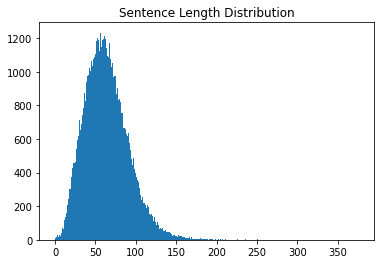

In [ ]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))
print('Data Size : ', len(cleaned_corpus))

for sen in cleaned_corpus:
  length = len(sen)
  if length < min_len:
    min_len = length
  if max_len < length:
    max_len = length
  sum_len += length

print('문장의 최단 길이 : ', min_len)
print('문장의 최장 길이 : ', max_len)
print('문장의 평균 길이 : ', sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:
  sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title('Sentence Length Distribution')
plt.show()

처음에 비해 분포 그래프가 깔끔해진 것을 볼 수 있습니다.
이제 여기서 생각해볼것은 모든 데이터를 전부 사용할것인가에 대한 것입니다.
데이터를 모델에 넣는다고 생각했을때 가장 긴 데이터를 기준으로 Padding처리를 해야합니다. 그 때를 고려하여 길이 150이 넘는 데이터는 제거하고 사용하도록 하겠습니다. 
그리고 길이가 너무 짧은 10미만인 데이터도 제거하도록 하겠습니다.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


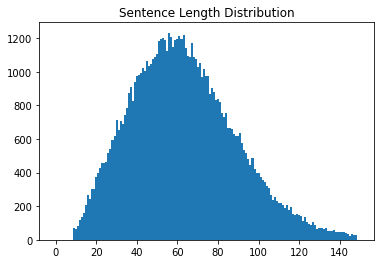

In [ ]:
max_len = 150
min_len = 10

filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) and (len(s) >= min_len)]

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
  sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title('Sentence Length Distribution')
plt.show()

## 공백 기반 토큰화

정제된 데이터를 공백 기반으로 토큰화하여 list에 저장한 후, 아래 tokenize() 함수를 사용해 단어 사전과 Tensor 데이터를 얻고, 단어 사전의 크기를 확인 해보겠습니다.

In [ ]:
def tokenize(corpus):
  tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  tokenizer.fit_on_texts(corpus)

  tensor = tokenizer.texts_to_sequences(corpus)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

  return tensor, tokenizer

In [ ]:
filtered_corpus[1]

'지도자들은 저항세력과 대화하는 데 동의했습니다.'

먼저 공백을 기준으로 문장을 나눠서 split_corpus 리스트에 넣어주겠습니다.

In [ ]:
split_corpus = []

for kor in filtered_corpus:
  split_corpus.append(kor.split())

In [ ]:
split_corpus[1:3]

[['지도자들은', '저항세력과', '대화하는', '데', '동의했습니다.'],
 ['barrage', '집중', '공세,', '집중', '사격']]

이제 공백 기반 토큰화를 진행한 후, 단어 사전의 길이를 확인해보겠습니다.


In [ ]:
split_tensor, split_tokenizer = tokenize(split_corpus)

print('Split Vocab Size : ', len(split_tokenizer.index_word))

Split Vocab Size :  237435


In [ ]:
# 생성된 단어 사전 확인

for idx, word in enumerate(split_tokenizer.word_index):
  print(idx, ':', word)

  if idx > 10:
    break

0 : 이
1 : 밝혔다.
2 : 있다.
3 : 말했다.
4 : 수
5 : 있는
6 : 그는
7 : 대한
8 : 위해
9 : 전했다.
10 : 지난
11 : 이번


결과를 보면 공백 기반 토큰화의 문제점을 확인할 수 있습니다. 1번의 밝혔다. 는 밝히다, 밝다 등과 유사한 의미이지만 전혀 다른 단어로 분류되어 있습니다. 이처럼 공백 기반 토큰화는 불필요하게 큰 단어 사전을 가지게 되며 이는 연산량 증가로 이어집니다.

만약에 밝+혔다 로 토큰화 했다면 밝+히다, 밝+다 같은 구절이 등장했을 때, 공통된 어절인 밝 은 하나로 묶여 학습 중 의미 파악이 쉬울것입니다. 이를 위해 형태소 분석기가 존재합니다.

## 형태소 기반 토큰화

한국어 형태소 분석기는 대표적으로 Khaiii 와 KoNLPy가 사용됩니다. 이번에는 KoNLPy의 MeCab클래스를 활용해 실습해보겠습니다.

In [ ]:
tokenizer = Mecab()

def mecab_split(sentence):
  tokenized_sentence = tokenizer.morphs(sentence)

  return tokenized_sentence

mecab_corpus = []

for kor in filtered_corpus:
  mecab_corpus.append(mecab_split(kor))

이제 형태소 기반 토큰화를 진행한 후의 단어 사전의 길이를 확인해보겠습니다.


In [ ]:
mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)

print('MeCab Vocab Size : ', len(mecab_tokenizer.word_index))

MeCab Vocab Size :  52279


앞에서 본 공백 기반 토큰화 진행 후의 단어 사전의 길이와 비교해보면 현저히 줄어든 것을 확인할 수 있습니다. 이는 곧 연산량을 감소로 이어져 더 빠른 학습을 가능하게 하고, 모델의 파라미터수를 줄어들게해 학습도 더 잘됩니다. 

https://aiopen.etri.re.kr/service_dataset.php

형태소 분석기로 유명한 KorBERT 모델의 구조를 볼 수 있는 링크입니다.

이번에는 tensor로 encoding된 문장을 다시 decoding 해보겠습니다.

In [ ]:
mecab_tensor

array([[  148,   272,    14, ...,     0,     0,     0],
       [  276,    14,     8, ...,     0,     0,     0],
       [32434,  1390,  5010, ...,     0,     0,     0],
       ...,
       [  390,     4,  3057, ...,     0,     0,     0],
       [ 2963,    15,   408, ...,     0,     0,     0],
       [   30,    15,   162, ...,     0,     0,     0]], dtype=int32)

In [ ]:
# Case 1 : tokenizer.sequences_to_texts()

texts = mecab_tokenizer.sequences_to_texts([mecab_tensor[100]])
texts[0]

'엘튼 존 은 이날 공식 웹 사이트 를 통해 ‘ 클 래라 앤드 이다 밸리 댄싱 ’( klara and edda belly - dancing ) 사진 의 주인 이 라고 말 했 다 .'

In [ ]:
sentence = ''

for w in mecab_tensor[100]:
  if w==0:
    continue
  sentence += mecab_tokenizer.index_word[w]+ ' '

print(sentence)

엘튼 존 은 이날 공식 웹 사이트 를 통해 ‘ 클 래라 앤드 이다 밸리 댄싱 ’( klara and edda belly - dancing ) 사진 의 주인 이 라고 말 했 다 . 


## SentencePiece 사용하기

라이브러리 버전을 한 번 확인해보겠습니다.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import konlpy

print(tf.__version__)
print(np.__version__)
print(matplotlib.__version__)
print(konlpy.__version__)

2.8.2
1.21.6
3.2.2
0.6.0


1. SentencePiece 설치

https://github.com/google/sentencepiece

위 링크에서 자세한 내용을 볼 수 있습니다.

In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


SentencePiece 모델을 학습하겠습니다.

In [ ]:
import sentencepiece as spm
temp_file_path = '/content/drive/MyDrive/AIFFEL/GoingDeeper(NLP)/2_단어사전만들기/korean-english-park.train.ko.temp2'

vocab_size = 8000

with open(temp_file_path, 'w') as f:
  for row in filtered_corpus:
    f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={} --model_type=unigram'.format(temp_file_path, vocab_size)
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

-rw-r--r-- 1 root root 376898 Sep 24 08:45 korean_spm.model
-rw-r--r-- 1 root root 146218 Sep 24 08:45 korean_spm.vocab


korean_spm.model, korean_spm.vocab 파일이 생성되었음을 볼 수 있습니다.

이제 학습된 SentencePiece 모델을 어떻게 활용하는지 살펴보겠습니다.

In [ ]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds("아버지가 방...에들어가신다.")
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',2 ,0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1243, 11, 830, 3, 3, 3, 7, 3608, 11, 287, 38, 3]
['▁아버지', '가', '방', '에', '들', '어', '가', '신', '다', '.']
아버지가 방...에들어가신다.


In [ ]:
s.EncodeAsIds('안녕하세요')

[277, 7746, 170, 103, 514]

In [ ]:
type('안녕하세요')

str

Tokenizer 함수 작성

바로 앞에서 훈련시킨 Sentencepiece를 활용하여 위 함수와 유사한 기능을 하는 sp_tokenize()함수를 정의하겠습니다. 함수는 아래 기능을 갖고 있습니다.

1. 매개변수로 토큰화된 문장의 리스트를 전달하는 게 아니라 온전한 문장의 리스트를 전달합니다.
2. 생성된 vocab 파일을 읽어와 { 단어 : 인덱스 } 형태를 가지는 word_index 사전과 {인덱스 : 단어} 형태를 가지는 index_word 사전을 생성하고 함께 반환합니다.
3. tensor는 토큰화한 후 인코딩된 문장입니다.(인덱스화)

In [ ]:
def sp_tokenize(s, corpus):
  tensor = []

  for sen in corpus:
    tensor.append(s.EncodeAsIds(sen))
  
  with open("./korean_spm.vocab", 'r') as f:
    vocab = f.readlines()
  
  word_index = {}
  index_word = {}

  for idx, line in enumerate(vocab):
    word = line.split("\t")[0]

    word_index.update({word:idx})
    index_word.update({idx:word})
  
  tensor = tensorflow.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

  return tensor, word_index, index_word

In [ ]:
# 사용 예시

my_corpus =['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

## 실습. 영화리뷰 감성 분석

이번엔 SentencePiece를 이용해 네이버 영화리뷰 감정 분석을 해보겠습니다.

그리고 KoNLPy에 Mecab의 결과와 비교해보겠습니다.

### SentencePiece(unigram)

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf


train_data = pd.read_table('/content/drive/MyDrive/AIFFEL/GoingDeeper(NLP)/2_단어사전만들기/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/AIFFEL/GoingDeeper(NLP)/2_단어사전만들기/ratings_test.txt')


In [ ]:
train_data.shape

(150000, 3)

In [ ]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
all_data = pd.concat([train_data, test_data], axis=0, ignore_index=True)

In [ ]:
all_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
all_data.dropna(axis=0 ,inplace=True)

In [ ]:
all_data.shape

(199992, 3)

In [ ]:
# 중복치 제거
all_data=all_data.drop_duplicates('document', keep='first')

In [ ]:
all_data.shape

(194543, 3)

In [ ]:
sentence = (all_data['document'])
sentence

0                                       아 더빙.. 진짜 짜증나네요 목소리
1                         흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                         너무재밓었다그래서보는것을추천한다
3                             교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4         사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
                                ...                        
199995            오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함
199996         의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO
199997                   그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다
199998       절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네
199999                                           마무리는 또 왜이래
Name: document, Length: 194543, dtype: object

Min length :  1
Max length :  146
Average length :  36


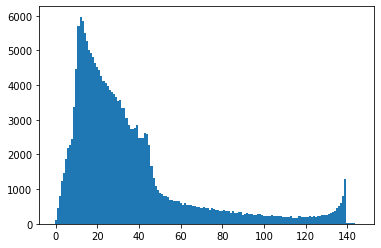

In [ ]:
import matplotlib.pyplot as plt


min_len = 999
max_len = 0
sum_len = 0

for s in sentence:
  if len(s) > max_len:
    max_len = len(s)
  if len(s) < min_len:
    min_len = len(s)
  sum_len += len(s)

print('Min length : ', min_len)
print('Max length : ', max_len)
print('Average length : ', sum_len // len(sentence))

sen_length_cnt = [0] * max_len
for sen in sentence:
  sen_length_cnt[len(sen)-1] += 1

plt.bar(range(max_len), sen_length_cnt, width=1.0)
plt.show()

In [ ]:
max_len = 140
min_len = 10

filtered_sen = [] 
filtered_target = []  

target = np.array(all_data['label'])

for s, t in zip(sentence, target):
    if (len(str(s)) < max_len) & (len(str(s)) >= min_len):
        filtered_sen.append(s) 
        filtered_target.append(t)

print(len(filtered_sen))
print(len(filtered_target))

180320
180320


### SentencePiece Model 학습

    spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={} --model_type=unigram'.format(temp_file_path, vocab_size))

--input: one-sentence-per-line raw corpus file. No need to run tokenizer, normalizer or preprocessor. By default, SentencePiece normalizes the input with Unicode NFKC. You can pass a comma-separated list of files.  
--model_prefix: output model name prefix. <model_name>.model and <model_name>.vocab are generated.  
--vocab_size: vocabulary size, e.g., 8000, 16000, or 32000  
--character_coverage: amount of characters covered by the model, good defaults are: 0.9995 for languages with rich character set like Japanese or Chinese and 1.0 for other languages with small character set.    
--model_type: model type. Choose from unigram (default), bpe, char, or word. The input sentence must be pretokenized when using word type.  

In [ ]:
import sentencepiece as spm
temp_file_path = '/content/drive/MyDrive/AIFFEL/GoingDeeper(NLP)/2_단어사전만들기/ratings_test.txt.temp'

vocab_size = 16000

with open(temp_file_path, 'w') as f:
  for row in filtered_sen:
    f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={} --model_type=unigram'.format(temp_file_path, vocab_size)
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

-rw-r--r-- 1 root root 534123 Sep 24 08:45 korean_spm.model
-rw-r--r-- 1 root root 310483 Sep 24 08:45 korean_spm.vocab


앞에서 만들어둔 함수를 이용해 토큰화를 진행해보겠습니다. 

In [ ]:
def sp_tokenize(s, corpus):
  tensor = []

  for sen in corpus:
    tensor.append(s.EncodeAsIds(sen))
  
  with open("./korean_spm.vocab", 'r') as f:
    vocab = f.readlines()
  
  word_index = {}
  index_word = {}

  for idx, line in enumerate(vocab):
    word = line.split("\t")[0]

    word_index.update({word:idx})
    index_word.update({idx:word})
  
  tensor = tensorflow.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')

  return tensor, word_index, index_word

샘플로 한 번 뽑아보겠습니다.

만약 잘 되는게 확인이 된다면 전체 데이터에 대해서 적용시켜 주겠습니다.

In [ ]:
import tensorflow

s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')
tensor, word_index, index_word = sp_tokenize(s, sentence[1:3])

In [ ]:
print(tensor)

[[ 1659     7  4930   152  1482    34   408    52   184   747   410  1444
   8146   828   397]
 [    0     0     0     0     0     0    20   467     0   437  3308 13125
     14  2320   320]]


In [ ]:
sentence[1], sentence[2]

('흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나', '너무재밓었다그래서보는것을추천한다')

In [ ]:
# 전체 데이터 전처리 + 토큰화
tensor, word_index, index_word = sp_tokenize(s, filtered_sen)

In [ ]:
print(tensor.shape)
print(tensor)
print(len(word_index))
print(len(index_word))

(180320, 132)
[[   0    0    0 ... 2190   79 1312]
 [   0    0    0 ... 8146  828  397]
 [   0    0    0 ...   14 2320  320]
 ...
 [   0    0    0 ... 5158  114 2250]
 [   0    0    0 ...  366  964   57]
 [   0    0    0 ...   13  162 3473]]
16000
16000


SentencePiece를 이용해 토큰화, 단어 인덱싱, 패딩 등의 과정을 전부 거쳤으니 감성 분류 모델을 설계하고 학습 시켜보겠습니다.

그리고 훈련 데이터와 테스트 데이터를 나눠야 하는데

훈련, 평가 비율은 8:2 로 하겠습니다.

In [ ]:
# 데이터 나누기
from sklearn.model_selection import train_test_split

x_train, val_x, y_train, val_y = train_test_split(tensor, filtered_target, test_size=0.2)
y_train = np.array(y_train)
val_y = np.array(val_y)

In [ ]:
x_train.shape, y_train.shape, val_x.shape, val_y.shape

((144256, 132), (144256,), (36064, 132), (36064,))

In [ ]:
# LSTM 모델 설계
import tensorflow as tf

vocab_size = vocab_size
word_vector_dim = 200

model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(tf.keras.layers.LSTM(128))
model_lstm.add(tf.keras.layers.Dense(32, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         3200000   
                                                                 
 lstm (LSTM)                 (None, 128)               168448    
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,372,609
Trainable params: 3,372,609
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 모델 훈련

epochs = 2
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=5)

model_lstm.compile(optimizer='adam',
             loss = 'binary_crossentropy',
             metrics=['accuracy'])

history_lstm = model_lstm.fit(x_train,
                              y_train,
                              epochs=epochs,
                              batch_size=128,
                              validation_data=(val_x, val_y),
                              verbose=1)

Epoch 1/2
1127/1127 [==============================] - 20s 16ms/step - loss: 0.3753 - accuracy: 0.8308 - val_loss: 0.3176 - val_accuracy: 0.8625
Epoch 2/2
1127/1127 [==============================] - 17s 15ms/step - loss: 0.2666 - accuracy: 0.8870 - val_loss: 0.3107 - val_accuracy: 0.8657


In [ ]:
# 시각화할 수 있는 항목 체크
history_dict = history_lstm.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

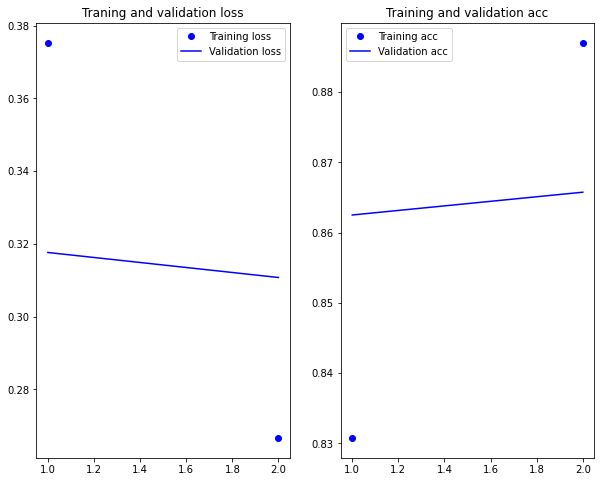

In [ ]:
loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8))
ax1.plot(epochs, loss, 'bo', label='Training loss')
ax1.plot(epochs, val_loss, 'b', label='Validation loss')
ax1.set_title('Traning and validation loss')
ax1.legend()

ax2.plot(epochs, acc, 'bo', label='Training acc')
ax2.plot(epochs, val_acc, 'b', label='Validation acc')
ax2.set_title('Training and validation acc')
ax2.legend()
plt.show()


## 결과

1. sentencepiece 1
  - 문장 길이 : 10 ~ 60
  - 단어장 크기 : 16000
  - 패딩 : post
  - 임베딩 차원 : 200
  - 배치사이즈 : 128
  - 에폭 20
  - loss: 0.0149 - accuracy: 0.9956 - val_loss: 0.9434 - val_accuracy: 0.8228

2. sentencepiece 2
  - 문장 길이 : 5 ~ 100
  - 단어장 크기 : 16000
  - 패딩 : post
  - 임베딩 차원 : 200
  - 배치 사이즈 : 128
  - 에폭 : 20
  - loss: 0.6932 - accuracy: 0.5018 - val_loss: 0.6932 - val_accuracy: 0.4957

3. sentencepiece 3
  - 문장 길이 : 5 ~ 100
  - 단어장 크기 : 16000
  - 패딩 : pre
  - 임베딩 차원 : 200
  - 배치 사이즈 : 128
  - 에폭 : 20
  - loss: 0.0058 - accuracy: 0.9981 - val_loss: 1.3404 - val_accuracy: 0.8271

4. sentencepiece 4
  - 문장 길이 : 전부
  - 단어장 크기 : 16000
  - 패딩 : pre
  - 임베딩 차원 200
  - 배치 사이즈 : 128
  - 에폭 : 10

5. sentencepiece 5
  - 단어장 크기 : 32000
  - 나머지 4와 동일
  - loss: 0.0293 - accuracy: 0.9886 - val_loss: 1.1246 - val_accuracy: 0.8195

6. sentencepiece 6
  - 문장 길이 : 5 ~ 80
  - 나머지 5와 동일
  - loss: 0.0097 - accuracy: 0.9965 - val_loss: 1.2195 - val_accuracy: 0.8295

7. sentencepiece 7
  - 문장 길이 : 10 ~ 80
  - 임베딩 차원 100
  - 나머지 6과 동일
  - loss: 0.0642 - accuracy: 0.9752 - val_loss: 0.7159 - val_accuracy: 0.8366

8. sentencepiece 8
  - 문장 길이 : 10 ~ 140
  - 단어장 크기 : 8000
  - 임베딩 차원 : 200
  - 나머지 7과 동일
  - loss: 0.2945 - accuracy: 0.8719 - val_loss: 0.3251 - val_accuracy: 0.8598

결과로 보면 문장의 길이가 너무 짧은 문장을 sentencepiece 모델에 학습시키게 되면 오히려 성능이 안좋아지는 것을 확인할 수 있음.

너무 짧은 문장은 버리는 게 좋을 것 같다. 그리고 단어장이 무조건 크다고 좋은것도 아닌 것 같다.



### SentencePiece(bpe)

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf


train_data = pd.read_table('/content/drive/MyDrive/AIFFEL/GoingDeeper(NLP)/2_단어사전만들기/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/AIFFEL/GoingDeeper(NLP)/2_단어사전만들기/ratings_test.txt')

In [ ]:
# 모델 합치기, 결측치 제거, 중복치 제거
all_data = pd.concat([train_data, test_data], axis=0, ignore_index=True)
all_data.dropna(axis=0 ,inplace=True)
all_data=all_data.drop_duplicates('document', keep='first')

all_data.shape

(194543, 3)

In [ ]:
sentence = (all_data['document'])


max_len = 140
min_len = 10

filtered_sen = [] 
filtered_target = []  

target = np.array(all_data['label'])

for s, t in zip(sentence, target):
    if (len(str(s)) < max_len) & (len(str(s)) >= min_len):
        filtered_sen.append(s) 
        filtered_target.append(t)

print(len(filtered_sen))
print(len(filtered_target))

180320
180320


In [ ]:
import sentencepiece as spm
temp_file_path = '/content/drive/MyDrive/AIFFEL/GoingDeeper(NLP)/2_단어사전만들기/ratings_test.txt.temp'

vocab_size = 16000

with open(temp_file_path, 'w') as f:
  for row in filtered_sen:
    f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={} --model_type=bpe'.format(temp_file_path, vocab_size)
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

-rw-r--r-- 1 root root 523592 Sep 24 08:47 korean_spm.model
-rw-r--r-- 1 root root 258735 Sep 24 08:47 korean_spm.vocab


In [ ]:
import tensorflow

s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# 전체 데이터 전처리 + 토큰화
tensor, word_index, index_word = sp_tokenize(s, filtered_sen)

In [ ]:
# 데이터 나누기
from sklearn.model_selection import train_test_split

x_train, val_x, y_train, val_y = train_test_split(tensor, filtered_target, test_size=0.2)
y_train = np.array(y_train)
val_y = np.array(val_y)

In [ ]:
# LSTM 모델 설계
import tensorflow as tf

vocab_size = vocab_size
word_vector_dim = 200

model_lstm_bpe = tf.keras.Sequential()
model_lstm_bpe.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm_bpe.add(tf.keras.layers.LSTM(128))
model_lstm_bpe.add(tf.keras.layers.Dense(32, activation='relu'))
model_lstm_bpe.add(tf.keras.layers.Dense(1, activation='sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model_lstm_bpe.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 200)         3200000   
                                                                 
 lstm_1 (LSTM)               (None, 128)               168448    
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,372,609
Trainable params: 3,372,609
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 모델 훈련

epochs = 5
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=5)

model_lstm_bpe.compile(optimizer='adam',
             loss = 'binary_crossentropy',
             metrics=['accuracy'])

history_lstm_bpe = model_lstm_bpe.fit(x_train,
                              y_train,
                              epochs=epochs,
                              batch_size=128,
                              validation_data=(val_x, val_y),
                              verbose=1)

Epoch 1/5
1127/1127 [==============================] - 17s 14ms/step - loss: 0.3754 - accuracy: 0.8296 - val_loss: 0.3242 - val_accuracy: 0.8601
Epoch 2/5
1127/1127 [==============================] - 15s 13ms/step - loss: 0.2679 - accuracy: 0.8858 - val_loss: 0.3282 - val_accuracy: 0.8649
Epoch 3/5
1127/1127 [==============================] - 15s 13ms/step - loss: 0.2101 - accuracy: 0.9134 - val_loss: 0.3344 - val_accuracy: 0.8616
Epoch 4/5
1127/1127 [==============================] - 15s 14ms/step - loss: 0.1551 - accuracy: 0.9372 - val_loss: 0.4055 - val_accuracy: 0.8561
Epoch 5/5
1127/1127 [==============================] - 15s 13ms/step - loss: 0.1075 - accuracy: 0.9579 - val_loss: 0.4868 - val_accuracy: 0.8471


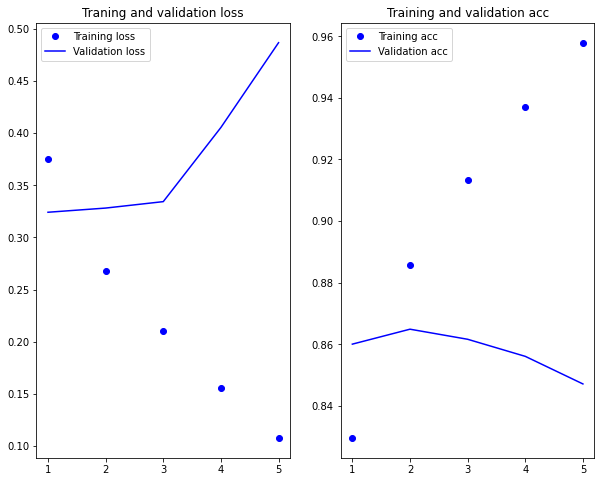

In [ ]:
# 시각화할 수 있는 항목 체크
history_dict = history_lstm_bpe.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8))
ax1.plot(epochs, loss, 'bo', label='Training loss')
ax1.plot(epochs, val_loss, 'b', label='Validation loss')
ax1.set_title('Traning and validation loss')
ax1.legend()

ax2.plot(epochs, acc, 'bo', label='Training acc')
ax2.plot(epochs, val_acc, 'b', label='Validation acc')
ax2.set_title('Training and validation acc')
ax2.legend()
plt.show()


### Mecab 이용해서 모델 학습

지금까지 sentencepiece 를 이용해봤으니 이제 mecab을 이용하여 보겠습니다.

sentencepiece는 따로 전처리를 하지 않은 raw text를 그대로 받아서 학습했지만 여기서는 전처리를 진행해줘야 합니다.

전처리는 크게

1. 구두점 제거
2. 불용어 제거  

이 두 가지 전처리를 진행하겠습니다.

불용어를 제거할 때 불용서를 모아놓은 .txt 파일을 읽어서 사용해주겠습니다.

### Mecab

먼저 데이터를 다시 불러오겠습니다.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf


train_data = pd.read_table('/content/drive/MyDrive/AIFFEL/GoingDeeper(NLP)/2_단어사전만들기/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/AIFFEL/GoingDeeper(NLP)/2_단어사전만들기/ratings_test.txt')


In [ ]:
train_data.shape, test_data.shape

((150000, 3), (50000, 3))

In [ ]:
# 두 데이터 합치기
all_data = pd.concat([train_data, test_data], axis=0, ignore_index=True)
all_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
all_data.tail()

,id,document,label
199995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
199996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
199997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
199998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0
199999,6070594,마무리는 또 왜이래,0


load_data 함수를 구현하여 아래 기능을 한 번에 실행해주겠습니다. 포함하는 기능은 아래와 같습니다.
1. 데이터의 중복 제거
2. 결측치 제거
3. 한국어 토크나이저로 토큰화
4. 불용어 제거
5. 사전 구성
6. 텍스트 스트링을 사전 인덱스 스트링으로 변환
7. x_train, y_train, val_x, val_y, word_to_index 리턴

불용어는 만들어진 불용어 파일을 이용해 제거해주겠습니다.

In [ ]:
stop_file_path = '/content/drive/MyDrive/AIFFEL/GoingDeeper(NLP)/2_단어사전만들기/stopwords.txt'

with open(stop_file_path) as f:
  lines = f.read().splitlines()


In [ ]:
stopwords_list = lines

In [ ]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer_mecab = Mecab()

def load_data(train_data, test_data, num_words=16000):
  len_train = len(train_data)

  all_data = pd.concat([train_data, test_data], axis=0, ignore_index=True)
  all_data = all_data.drop_duplicates('document', keep='first')
  all_data = all_data.dropna(axis=0)

  sentence_list = list(all_data['document'])

  token_list = []
  for sen in sentence_list:
    tokenize_sentence = tokenizer_mecab.morphs(sen)
    tokenize_sentence = [word for word in tokenize_sentence if word not in stopwords_list]
    token_list.append(tokenize_sentence)
  
  x_train = token_list[:len_train]
  val_x = token_list[len_train:]

  words = np.concatenate(x_train).tolist()
  counter = Counter(words)
  counter = counter.most_common(15000-4)
  vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
  
  word2index = {word : index for index, word in enumerate(vocab)}

  def wordlist_to_indexlist(wordlist):
    return [word2index[word] if word in word2index else word2index['<UNK>'] for word in wordlist]
  
  x_train=np.array(list(map(wordlist_to_indexlist, x_train)), dtype=object)
  val_x = np.array(list(map(wordlist_to_indexlist, val_x)), dtype=object)

  return x_train, np.array(list(all_data['label'][:len_train]), dtype=object), val_x, np.array(list(all_data['label'][len_train:]), dtype=object), word2index




In [ ]:
x_train, y_train, val_x, val_y, word2index = load_data(train_data, test_data)

In [ ]:
index2word = {index : word for word, index in word2index.items()}

In [ ]:
# 문장 1개를 활용할 딕셔너리와 함께 주면 ,단어 인덱스 리스트 벡터로 변환해 주는 함수입니다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다.
def get_encoded_sentence(sentence, word_to_index):
  return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
  return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다.
def get_decoded_sentence(encoded_sentence, index_to_word):
  return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])
  
# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
  return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

토큰화된 문장들의 길이분포를 확인하고 최대 문장 길이를 지정해주겠습니다.

In [ ]:
total_data_text = list(x_train) + list(val_x)

# 텍스트데이터 문장길이의 리스트를 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + 2 * 표준편차) 로 한다면 남는 문장의 비율은?
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.31643903918414
문장길이 최대 :  116
문장길이 표준편차 :  12.220230883270801
pad_sequences maxlen :  39
전체 문장의 0.9337370144389672%가 maxlen 설정값 이내에 포함됩니다. 


In [ ]:
import tensorflow as tf

# 문장의 마지막 입력이 최종 state에 영향을 가장 크게 미치기 때문에 패딩 적용은 pre(앞쪽)으로 해줍니다.
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word2index['<PAD>'],
                                                        padding = 'pre',
                                                        maxlen = maxlen)
 

val_x = tf.keras.preprocessing.sequence.pad_sequences(val_x,
                                                       value=word2index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(x_train.shape)


(150000, 39)


In [ ]:
x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.float32)
val_x = val_x.astype(np.float32)
val_y = val_y.astype(np.float32)

In [ ]:
vocab_size = 16000
word_vector_dim = 200

model_lstm_mecab = tf.keras.Sequential()
model_lstm_mecab.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm_mecab.add(tf.keras.layers.LSTM(128))
model_lstm_mecab.add(tf.keras.layers.Dense(32, activation='relu'))
model_lstm_mecab.add(tf.keras.layers.Dense(1, activation='sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model_lstm_mecab.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 200)         3200000   
                                                                 
 lstm_2 (LSTM)               (None, 128)               168448    
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,372,609
Trainable params: 3,372,609
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_lstm_mecab.compile(optimizer = 'adam',
                         loss = 'binary_crossentropy',
                         metrics=['accuracy'])

epochs = 2

history_lstm_mecab = model_lstm_mecab.fit(x_train,
                                          y_train,
                                          epochs=epochs,
                                          batch_size=64,
                                          validation_data=(val_x, val_y),
                                          )

Epoch 1/2
2344/2344 [==============================] - 17s 7ms/step - loss: 0.3622 - accuracy: 0.8380 - val_loss: 0.3355 - val_accuracy: 0.8556
Epoch 2/2
2344/2344 [==============================] - 15s 6ms/step - loss: 0.2732 - accuracy: 0.8845 - val_loss: 0.3204 - val_accuracy: 0.8635


In [ ]:
history_mecab_dict = history_lstm_mecab.history
history_mecab_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

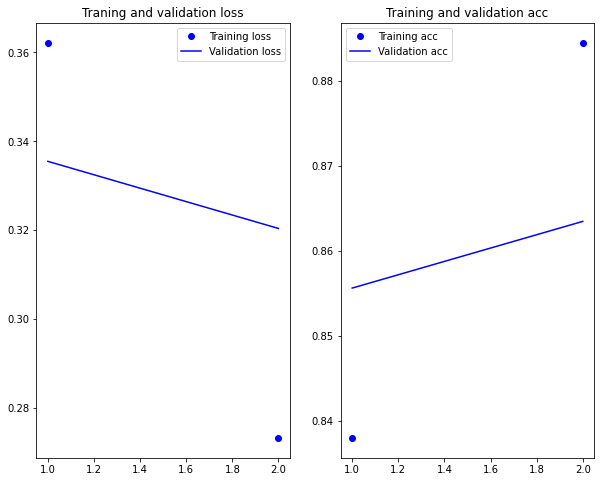

In [ ]:
import matplotlib.pyplot as plt

loss = history_mecab_dict['loss']
val_loss = history_mecab_dict['val_loss']
acc = history_mecab_dict['accuracy']
val_acc = history_mecab_dict['val_accuracy']

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8))
ax1.plot(epochs, loss, 'bo', label='Training loss')
ax1.plot(epochs, val_loss, 'b', label='Validation loss')
ax1.set_title('Traning and validation loss')
ax1.legend()

ax2.plot(epochs, acc, 'bo', label='Training acc')
ax2.plot(epochs, val_acc, 'b', label='Validation acc')
ax2.set_title('Training and validation acc')
ax2.legend()
plt.show()

## 결과 비교

| 전처리, 파라미터 | SentencePiece(unigram) | SentencePiece(BPE) | Mecab |
|:---:|:---:|:---:|:---:|
|Vocab Size|16000 |16000 | 16000|
|문장 길이|10 ~ 140 |10~140 | (토큰의 개수 기준) 39|
|패딩 위치| pre| pre|pre |
|임베딩 차원| 200| 200|200 |
|LSTM hidden size| 128|128|128 |
|batch size| 128 | 128| 64|
|Validation loss(가장 낮을 때 기준)|0.3107 |0.3282 | 0.3204|
|Validation accuracy(가장 높을 때 기준)|0.8657 |0.8649 |0.8635 |


이번에 처음 SentencePiece 모델을 사용해봤는데 전처리 없이 그냥 raw text를 그대로 받아서 학습하고 토큰화와 인덱싱까지 해주는 게 너무 편했습니다. Mecab을 사용하려면 기본적인 불용어 제거, 구두점 제거 등의 전처리를 진행해줘야 하는 귀찮음(?)이 있었는데 그게 없는게 가장 컸습니다. 거기에 성능까지 준수하기 때문에 정말 안 쓸 이유가 없는 모델인 것 같습니다.

그리고 처음에 LMS에서는 패딩을 'post'로 하는데 LSTM에 들어갈 때 패딩은 'pre'로 하는 게 더 좋다고 들어서 왜 이렇게 하는거지? 라는 생각이 들었습니다.   
그래도 일단 'post'로 진행해봤는데 성능이 너무 안좋아서 'pre'로 바꿔주니 확실히 성능이 좋아졌습니다.  
그리고 문장의 길이에 따른 성능을 볼 때도 처음에 문장을 전부 다 쓰면 데이터가 많으니까 좋겠지?? 하고 전부 다 사용했습니다. 그랬더니 그래프가 미친듯한 과적합 양상을 보여서 놀래서 중단했습니다. ㅎㅎ;  
그 후로  5 ~ 80, 10 ~ 80, 10~140 으로 길이를 바꿔가며 진행 했는데 문장의 길이가 길어지는 것은 성능에 그렇게 큰 영향을 끼치진 않았지만 길이가 너무 짧은(10 미만)문장들은 오히려 성능에 악영향을 끼치는 모습을 보였습니다. 앞으로 문장의 길이가 너무 짧은 것들은 얄짤없이 다 버려야겠습니다.  

이번에 처음으로 Mecab대신 다른 SentencePiece라는 모델을 사용해봤는데 전처리가 필요없이 아주 준수한 성능을 내는 모델이란 걸 알았고 다음에 데이터 전처리를 할 때는 웬만해서는 SentencePiece 모델을 사용할 것 같습니다. 